In [13]:
import tensorflow as tf

In [15]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install tensorflow_datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 18.8 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 19.8 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=8d999f7cb21ffaef207530cb3b4407598a81c9be6c294a20958393582fce0d93
  Stored in directory: /home/staj/.cache/pip/wheels/90/74/b1/9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [26]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)



In [27]:
#Download the Flowers Dataset using TensorFlow Datasets
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', 
                                                         split = ['train[:70%]', 'train[70%:]'], 
                                                         with_info=True, 
                                                         as_supervised=True,)

2023-08-08 11:38:31.213158: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/staj/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [39]:
#Print Information about the Flowers Dataset
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples +=1
    
for example in validation_set:
    num_validation_examples += 1
    
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} /n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 /n


In [40]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [47]:
#Reformat Images and Create Batches
#In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. 
#Then create training and validation batches of size 32.

IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [48]:
#Create a Feature Extractor

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [49]:
#Freeze the Pre-Trained Model

feature_extractor.trainable = False

In [50]:
#Attach a classification head

model = tf.keras.Sequential([feature_extractor, layers.Dense(num_classes)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [51]:
# Train the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)


Epoch 1/6
81/81 [==============================] - 51s 582ms/step - loss: 0.8448 - accuracy: 0.6956 - val_loss: 0.4682 - val_accuracy: 0.8638
Epoch 2/6
81/81 [==============================] - 43s 535ms/step - loss: 0.3863 - accuracy: 0.8669 - val_loss: 0.3848 - val_accuracy: 0.8638
Epoch 3/6
81/81 [==============================] - 42s 514ms/step - loss: 0.3034 - accuracy: 0.9031 - val_loss: 0.3470 - val_accuracy: 0.8847
Epoch 4/6
81/81 [==============================] - 42s 517ms/step - loss: 0.2499 - accuracy: 0.9183 - val_loss: 0.3246 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 42s 520ms/step - loss: 0.2175 - accuracy: 0.9416 - val_loss: 0.2941 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 41s 510ms/step - loss: 0.1901 - accuracy: 0.9506 - val_loss: 0.2884 - val_accuracy: 0.9055


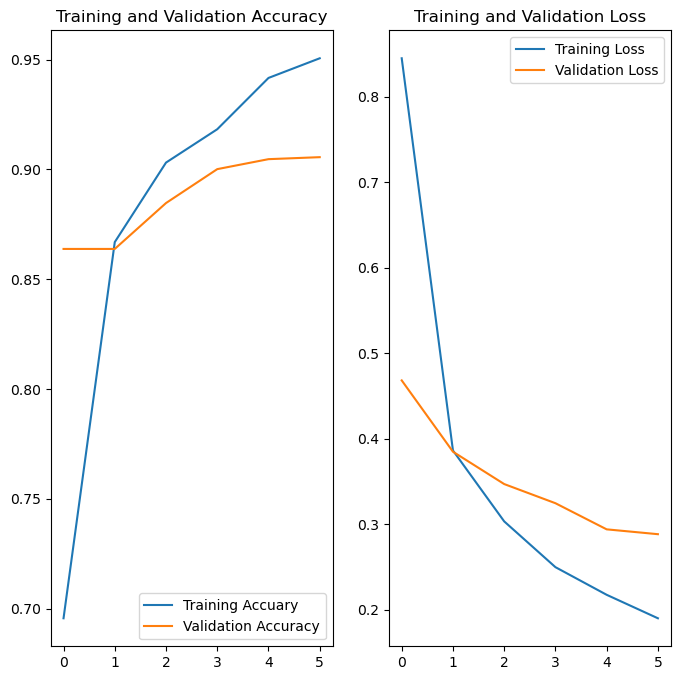

In [53]:
#Plot Training and Validation Graphs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuary')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
#Check Predictions

class_names = np.array(dataset_info.features['label'].names)
                     
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [62]:
#Create an Image Batch and Make Predictions

image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 477ms/step
['sunflowers' 'daisy' 'sunflowers' 'tulips' 'dandelion' 'tulips'
 'dandelion' 'tulips' 'dandelion' 'dandelion' 'roses' 'roses' 'sunflowers'
 'tulips' 'sunflowers' 'tulips' 'tulips' 'dandelion' 'roses' 'roses'
 'roses' 'dandelion' 'dandelion' 'sunflowers' 'tulips' 'tulips' 'tulips'
 'roses' 'dandelion' 'daisy' 'sunflowers' 'daisy']


In [63]:
#Print True Labels and Predicted Indices

print("Labels:               ", label_batch)
print("Predicted labels:     ", predicted_ids)

Labels:                [3 1 3 2 0 2 0 1 0 0 4 4 3 2 3 2 2 0 4 4 4 0 0 3 2 2 2 4 0 1 3 1]
Predicted labels:      [3 1 3 2 0 2 0 2 0 0 4 4 3 2 3 2 2 0 4 4 4 0 0 3 2 2 2 4 0 1 3 1]


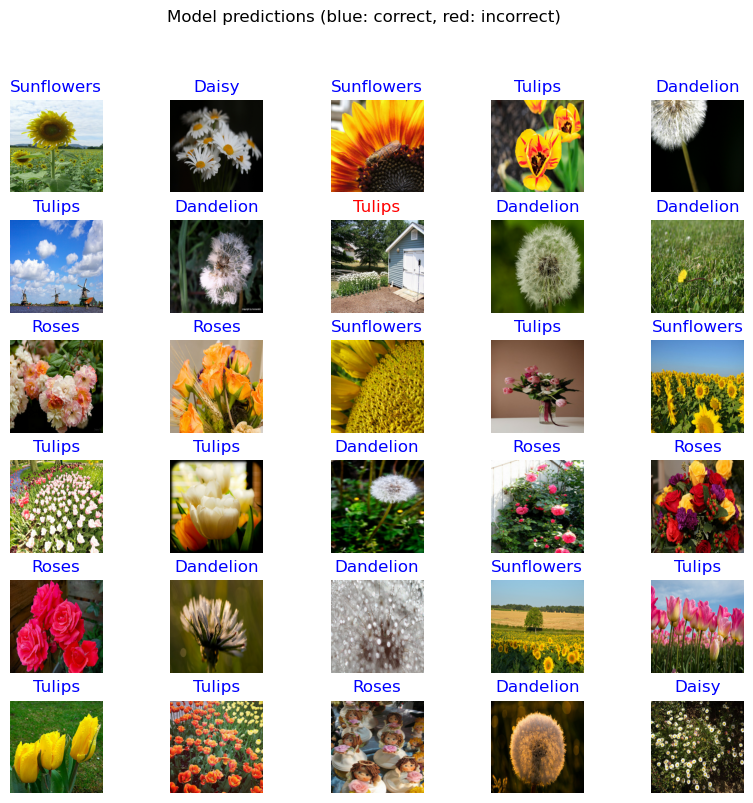

In [67]:
#Plot Model Predictions

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (blue: correct, red: incorrect)")


In [70]:
#Perform Transfer Learning with the Inception Model
#This feature vector corresponds to the Inception v3 model. In the cells below, 
#use transfer learning to create a CNN that uses Inception v3 as the pretrained model to 
#classify the images from the Flowers dataset. 
#Note that Inception, takes as input, images that are 299 x 299 pixels. 
#Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
'tf_flowers',
with_info=True,
as_supervised=True,
split=['train[:70%]', 'train[70%:]'],
)

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3),
                                  trainable=False)

model_inception= tf.keras.Sequential([feature_extractor,
                                     tf.keras.layers.Dense(num_classes)])

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [71]:
model_inception.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 176s 2s/step - loss: 0.7213 - accuracy: 0.7501 - val_loss: 0.4309 - val_accuracy: 0.8574
Epoch 2/6
81/81 [==============================] - 169s 2s/step - loss: 0.3845 - accuracy: 0.8774 - val_loss: 0.3552 - val_accuracy: 0.8828
Epoch 3/6
81/81 [==============================] - 169s 2s/step - loss: 0.3090 - accuracy: 0.9035 - val_loss: 0.3105 - val_accuracy: 0.8955
Epoch 4/6
81/81 [==============================] - 170s 2s/step - loss: 0.2592 - accuracy: 0.9237 - val_loss: 0.2953 - val_accuracy: 0.9010
Epoch 5/6
81/81 [==============================] - 169s 2s/step - loss: 0.2271 - accuracy: 0.9307 - val_loss: 0.2747 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 171s 2s/step - loss: 0.2025 - accuracy: 0.9443 - val_loss: 0.2689 - val_accuracy: 0.8983
